In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report,roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
df = pd.read_csv('Phishing_Email.csv',delimiter=',',encoding='latin-1')
df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Email Text  18634 non-null  object
 1   Email Type  18650 non-null  object
dtypes: object(2)
memory usage: 291.5+ KB


In [4]:
print(df.isna().sum())
print(df.duplicated().sum())

Email Text    16
Email Type     0
dtype: int64
1111


In [5]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [6]:
print(df.isna().sum())
print(df.duplicated().sum())

Email Text    0
Email Type    0
dtype: int64
0


C:\Users\ahmed\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of ham and spam messages')

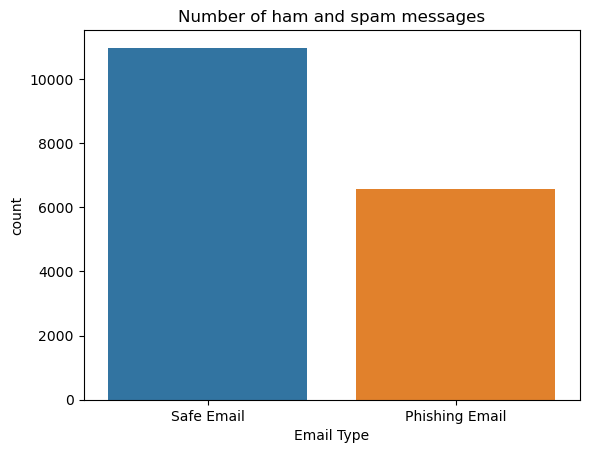

In [7]:
sns.countplot(df['Email Type'])
plt.xlabel('Email Type')
plt.title('Number of ham and spam messages')

In [8]:
x = df['Email Text']
y = df['Email Type']

le = LabelEncoder()

y = le.fit_transform(y)
y = y.reshape(-1,1)

In [9]:
#Split into training and test data.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 10)

### Process the data
##### Tokenize the data and convert the text to sequences.
##### Add padding to ensure that all the sequences have the same shape.
##### There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000
max_len = 150

tok = Tokenizer(num_words=max_words)

#Process the train set data
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences, maxlen=max_len)

#Process the test set data.
test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [12]:
sequences_matrix

array([[  30,   30, 2354, ...,    2, 1833, 4314],
       [  16,  105,  209, ...,  232,  328, 1508],
       [   0,    0,    0, ...,   31, 4644,  479],
       ...,
       [   0,    0,    0, ...,  553, 1302, 2021],
       [   0,    0,    0, ...,   63, 8957,   88],
       [   0,    0,    0, ..., 1998,   35,   31]])

In [13]:
sequences_matrix.shape

(14030, 150)

In [14]:
from keras.models import Sequential
from keras.layers import GRU, Dense,Embedding

model = Sequential()
model.add(Embedding(10000,32))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(sequences_matrix, y_train, epochs=20, batch_size=128, validation_data=(test_sequences_matrix, y_test))

Epoch 1/20
110/110 [==============================] - 15s 109ms/step - loss: 0.3789 - accuracy: 0.8267 - val_loss: 0.1698 - val_accuracy: 0.9518
Epoch 2/20
110/110 [==============================] - 12s 107ms/step - loss: 0.1072 - accuracy: 0.9679 - val_loss: 0.1105 - val_accuracy: 0.9544
Epoch 3/20
110/110 [==============================] - 12s 110ms/step - loss: 0.0614 - accuracy: 0.9802 - val_loss: 0.1128 - val_accuracy: 0.9547
Epoch 4/20
110/110 [==============================] - 13s 115ms/step - loss: 0.0432 - accuracy: 0.9867 - val_loss: 0.0787 - val_accuracy: 0.9735
Epoch 5/20
110/110 [==============================] - 13s 117ms/step - loss: 0.0302 - accuracy: 0.9907 - val_loss: 0.0744 - val_accuracy: 0.9783
Epoch 6/20
110/110 [==============================] - 13s 119ms/step - loss: 0.0218 - accuracy: 0.9942 - val_loss: 0.0779 - val_accuracy: 0.9786
Epoch 7/20
110/110 [==============================] - 13s 121ms/step - loss: 0.0166 - accuracy: 0.9954 - val_loss: 0.0762 - val_ac

In [17]:
loss, accuracy = model.evaluate(test_sequences_matrix, y_test)
print(f"Model Loss: {loss}\nModel Accuracy: {accuracy*100}")

110/110 [==============================] - 3s 23ms/step - loss: 0.1561 - accuracy: 0.9729
Model Loss: 0.15611891448497772
Model Accuracy: 97.29190468788147


Text(0, 0.5, 'Loss')

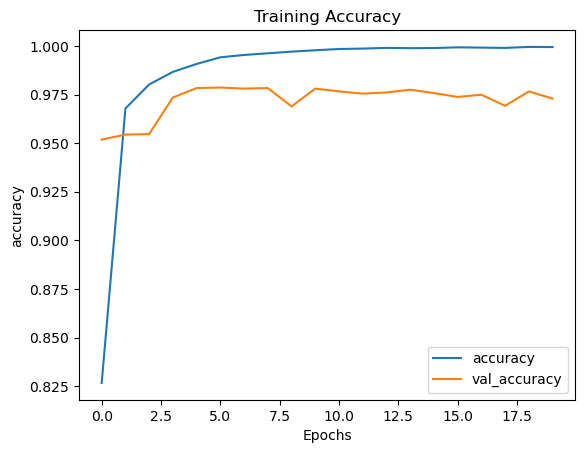

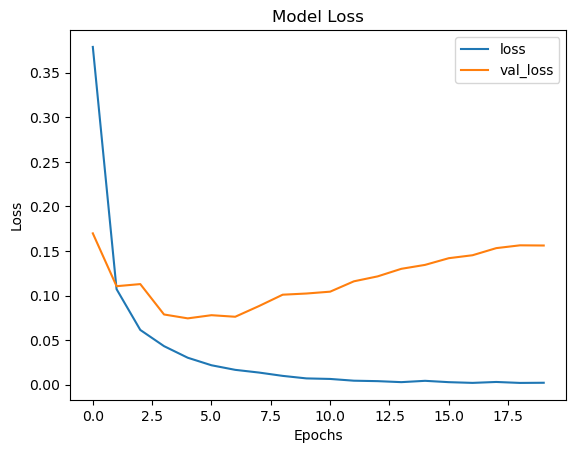

In [18]:
pd.DataFrame(history.history)

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [20]:
y_pred_prob = model.predict(test_sequences_matrix)
y_pred = (y_pred_prob > 0.5).astype(int)

110/110 [==============================] - 3s 22ms/step


In [21]:
# classification report
report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1259
           1       0.98      0.98      0.98      2249

    accuracy                           0.97      3508
   macro avg       0.97      0.97      0.97      3508
weighted avg       0.97      0.97      0.97      3508



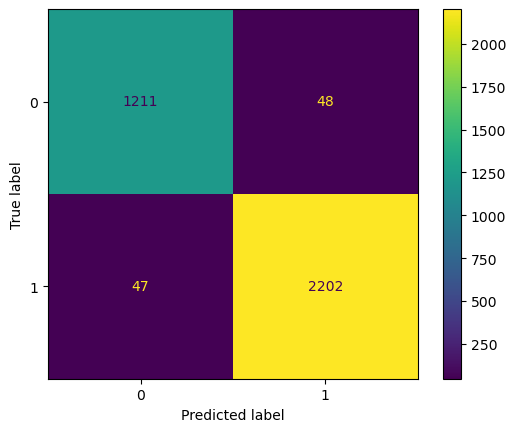

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# create a ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(cm)

# plot the confusion matrix
cm_display.plot()
plt.show()

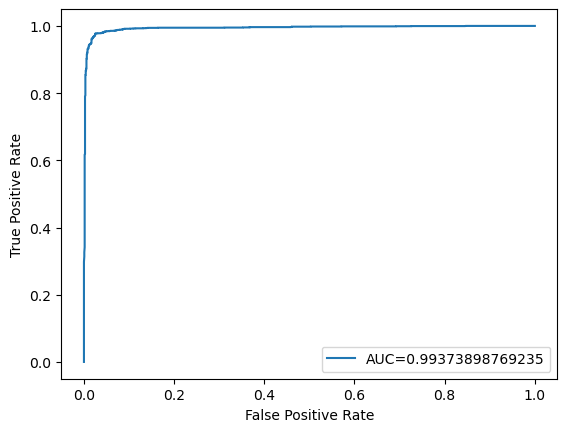

In [23]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [24]:
model.save("gru_phishing_emails_data.h5")